#  📌  **Bidirectional RNN - IMDB Dataset**

# Install Library

In [3]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00



# Import Library

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import LSTM,BatchNormalization, GRU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam, RMSprop, SGD


# Load Dataset & Preparation

In [5]:
# Parameter
num_words = 30000
maxlen = 500

# Load IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Konversi ke dictionary
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0)}


# **RNN Model**

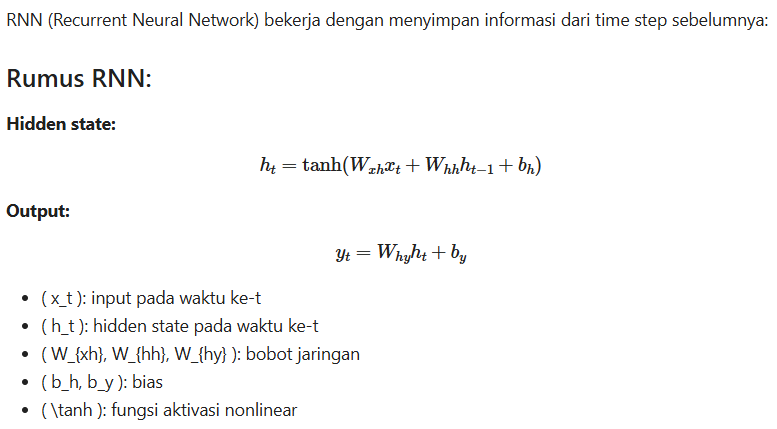

In [7]:
def build_model(hp):
    model = Sequential()

    # Embedding layer
    model.add(Embedding(
        input_dim=num_words,
        output_dim=hp.Int('embed_dim', 64, 256, step=64),
        input_length=maxlen
    ))

    # Fixed 2 Bidirectional RNN layers (but still tunable units & dropout)
    for i in range(2):
        return_seq = True if i == 0 else False
        model.add(Bidirectional(SimpleRNN(
            units=hp.Int(f'units_{i}', 32, 128, step=32),
            return_sequences=return_seq,
            dropout=hp.Float(f'dropout_rnn_{i}', 0.2, 0.5, step=0.1)
        )))
        model.add(BatchNormalization())

    # Fully connected layers (tunable jumlah dan unit)
    for j in range(hp.Int('num_dense_layers', 1, 2)):  # Tetap 1–2 layer
        model.add(Dense(
            units=hp.Int(f'dense_units_{j}', 64, 128, step=32),
            activation='relu'
        ))
        model.add(Dropout(hp.Float(f'dropout_dense_{j}', 0.2, 0.5, step=0.1)))

    # Output
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


# Hyperparameter Tuning

In [8]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='bidirectional_rnn_tuning'
)

tuner.search(
    x_train, y_train,
    epochs=5,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
)

best_model = tuner.get_best_models(num_models=1)[0]


Trial 5 Complete [00h 56m 33s]
val_accuracy: 0.8040000200271606

Best val_accuracy So Far: 0.8471999764442444
Total elapsed time: 04h 12m 57s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 23 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Latih Model

In [10]:
# Pastikan model sudah dikompilasi ulang jika diperlukan
best_model.compile(
    optimizer=best_model.optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Training lanjutan
history = best_model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    class_weight=class_weights
)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 418s 1s/step - accuracy: 0.8975 - loss: 0.2615 - val_accuracy: 0.8284 - val_loss: 0.4252
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.9119 - loss: 0.2261 - val_accuracy: 0.8100 - val_loss: 0.4210
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 446s 1s/step - accuracy: 0.9287 - loss: 0.1950 - val_accuracy: 0.8462 - val_loss: 0.3750
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.9324 - loss: 0.1867 - val_accuracy: 0.8472 - val_loss: 0.4490
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 452s 1s/step - accuracy: 0.9355 - loss: 0.1755 - val_accuracy: 0.8596 - val_loss: 0.3854
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - accuracy: 0.9158 - loss: 0.2223 - val_accuracy: 0.8528 - val_loss: 0.4633


# Evaluasi Model

In [12]:
# Evaluasi akhir pada data test
y_pred_prob = best_model.predict(x_test)  # Prediksi probabilitas
y_pred = (y_pred_prob > 0.5).astype(int)  # Ambil kelas berdasarkan threshold 0.5

# Menghitung metrik
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print("=====Hasil Evaluasi Model=====")
print(f"Akurasi: {acc:.4f}")
print(f"Presisi: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 152s 194ms/step
=====Hasil Evaluasi Model=====
Akurasi: 0.8443
Presisi: 0.8815
Recall: 0.7954
F1-Score: 0.8363
AUC: 0.9238


# Visulialisasi

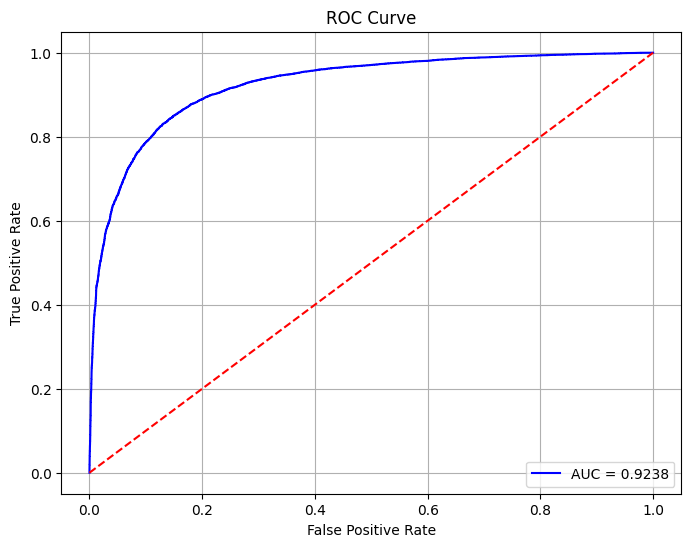

In [13]:
# Menghitung ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


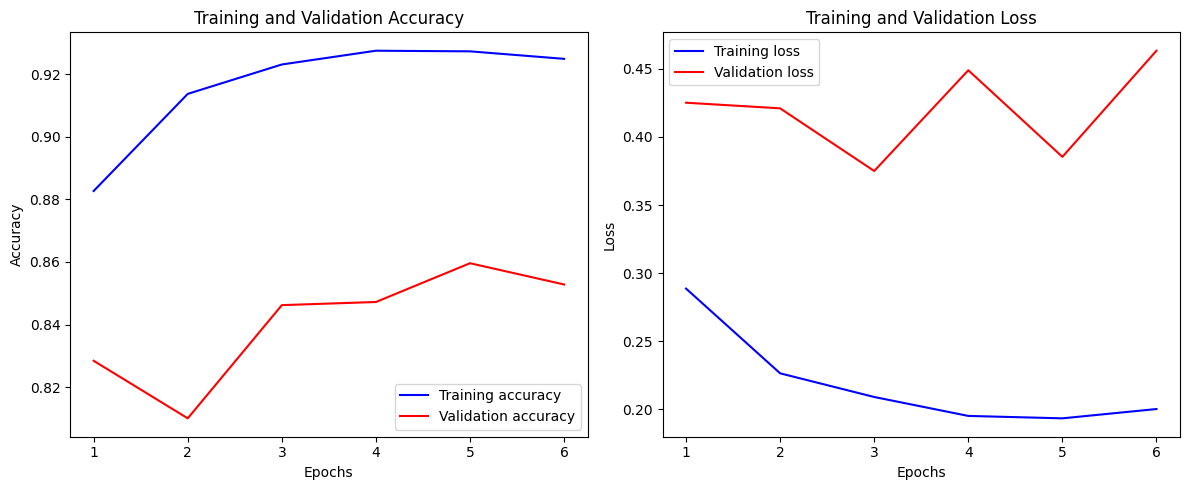

In [14]:
def plot_training_history(history):
    # Mengambil data dari history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)  # Membuat range untuk epoch

    # Plotting Akurasi
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()  # Untuk memperbaiki layout agar tidak tumpang tindih
    plt.show()

# Panggil fungsi untuk memvisualisasikan grafik
plot_training_history(history)
